Learn the inter-grid prolongation operator (P) for single-phase problems using multigrid framework,
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the same (3x3)
* Learn the kernel for a single phase Poisson problem

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v

In [3]:
n = 2**4
grid = SingleGrid(size=2,n=n)

In [4]:
training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_17x17.h5')
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)

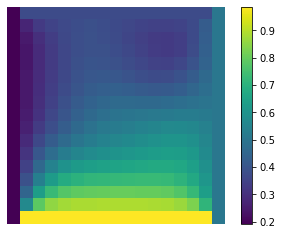

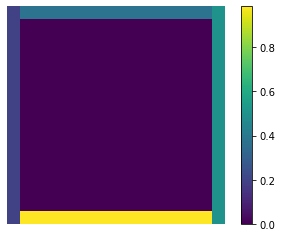

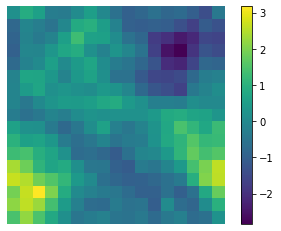

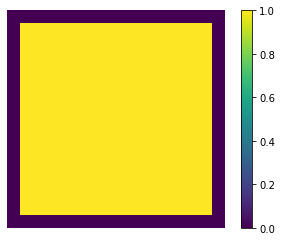

In [5]:
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0])
plot.plot_field(bc_value_train[k,0])
plot.plot_field(f_train[k,0])
plot.plot_field(bc_index_train[k,0])

0 2.5780715942382812
1 1.8588697910308838
2 1.476746678352356
3 1.235558271408081
4 1.0678542852401733
5 0.9437562227249146
6 0.8478343486785889
7 0.7712522745132446
8 0.7085606455802917
9 0.6562089920043945
10 0.6117845773696899
11 0.5735900402069092
12 0.5403958559036255
13 0.5112863183021545
14 0.485562264919281
15 0.46267732977867126
16 0.44219571352005005
17 0.4237637221813202
18 0.4070895314216614
19 0.39193034172058105
20 0.3780817687511444
21 0.36537066102027893
22 0.3536497950553894
23 0.34279343485832214
24 0.3326939344406128
25 0.3232591152191162
26 0.3144095242023468
27 0.3060773015022278
28 0.298203706741333
29 0.29073843359947205
30 0.28363797068595886
31 0.27686476707458496
32 0.27038660645484924
33 0.2641753554344177
34 0.25820669531822205
35 0.2524596154689789
36 0.24691583216190338
37 0.24155929684638977
38 0.23637592792510986
39 0.23135365545749664
40 0.22648170590400696
41 0.22175030410289764
42 0.21715129911899567
43 0.212677001953125
44 0.20832078158855438
45 0.20

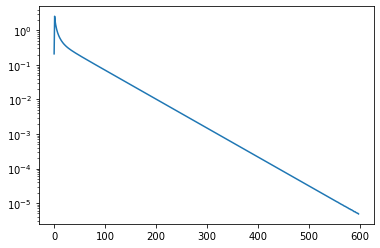

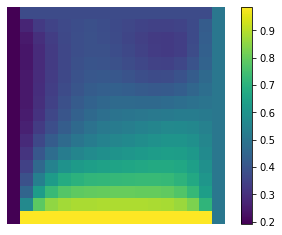

Solution from dataset:


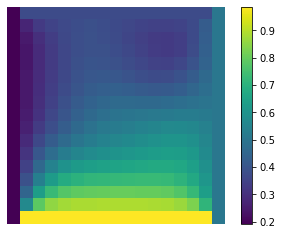

Error (dataset v.s. jacobi):


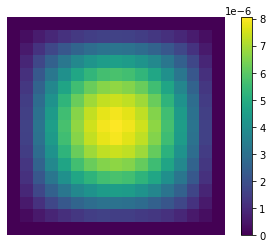

In [6]:
EPS = 5e-6
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
residual = f_test-grid.Knet(u_test)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.Relax(u_test, f_test, 1)
    residual = f_test-grid.Knet(u_test)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [7]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0

In [8]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 1
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
    def forward(self, x_split):
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 1
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        return self.net(x_split)

In [9]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_P):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids

        self.mse_loss = nn.MSELoss()
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_P)
        self.deconv = ProlongationNet(linear_tensor_P)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids        
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, u):
        "Compute the loss after m iterations, u is current solution; u_star is true solution"
        #err = u.clone() - u_star
        #return torch.mean(torch.norm(err, dim=(2,3)))
        #return self.mse_loss(u, u_star)
        res1 = self.f - self.grids[0].Knet(u)
        res0 = self.f - self.grids[0].Knet(self.v)
        return torch.mean(torch.pow(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/self.k))

    def random_sampling(self, v):
        d1, d2, d3, d4 = v.shape
        for i in range(d1):
            for j in range(d2):
                v[i, j, :, :] = torch.from_numpy(np.random.randn(d3,d4))

    def forward(self, F, bc_idx, bc_value, k):
        '''Input is RHS field F, boundary value B, iteration number k'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        self.random_sampling(self.v)
        self.grids[0].ResetBoundary(bc_idx, bc_value) # reset the boundary of finest grid
        self.k = k
        U = torch.clone(self.v)
        
        for i in range(k-1):
            U = self.iterate(U, self.f).detach()
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [10]:
n = 2**4
model = MultiGrid(n, linear_tensor_P+0.5*torch.rand((3,3)))

0 5.667733669281006
1 40.165122985839844
2 312.5195007324219
3 2437.77001953125
4 19012.5078125
5 148260.625
6 1156083.25
7 9014556.0
8 70290600.0
9 548086656.0
10 4273669376.0
11 33323636736.0
12 259838853120.0
13 2026075717632.0
14 15798184706048.0
15 123185282416640.0
16 960528834887680.0
17 7489655775690752.0
18 5.840008336795238e+16
19 4.553706777429934e+17
20 3.550720519542145e+18
21 inf
The iteration doesn't converge!


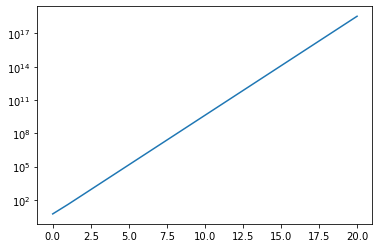

Multigrid solution:


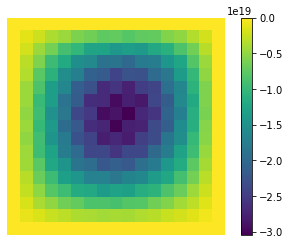

Jacobi solution:


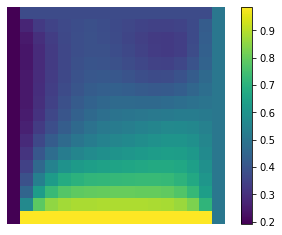

Solution from dataset:


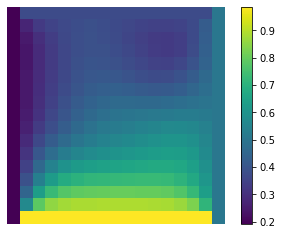

Error (dataset v.s. mg):


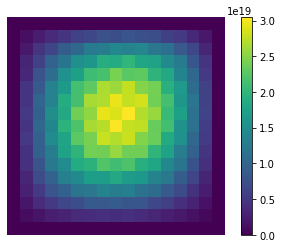

In [11]:
EPS = 5e-6
n_multigrid = 0
res_arr = []
res = 1
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model(f_mg, bc_idx_mg, bc_value_mg, 1)
err_occured = False
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [12]:
model_dir = 'Model/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Restriction kernel:', mlist[0][0][0])
print('Restriction kernel shape:', mlist[0].shape)
print('Interpolation kernel:', mlist[1][0][0])
print('Interpolation kernel shape:', mlist[1].shape)

Restriction kernel: tensor([[0.3640, 0.7616, 0.5547],
        [0.6923, 1.3740, 0.5432],
        [0.7167, 0.9834, 0.5455]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 1, 3, 3])
Interpolation kernel: tensor([[0.3640, 0.7616, 0.5547],
        [0.6923, 1.3740, 0.5432],
        [0.7167, 0.9834, 0.5455]])
Interpolation kernel shape: torch.Size([1, 1, 3, 3])


In [13]:
def copy_kernels(para_list):
    '''Copy the values of R kernels to P kernels'''
    para_list[1][0,:] = para_list[0][:,0].detach()

In [14]:
model_name = 'poisson_mg_kernel'

def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        u_train, f_train, bc_value_train, bc_index_train = data
        
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(f_train, bc_index_train, bc_value_train, random.randint(3,8))
        loss_i = model.loss(u_out)
        
        loss_i.backward()
        para_list = list(model.parameters())
        optimizer.step()
        copy_kernels(para_list) # update the P kernels
        
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss, para_list[0][0,0].data

In [15]:
num_epoch = 2000
best_vloss = 1_000_000.

loss_train = []
kernel_train = torch.zeros((num_epoch, 3, 3))
for epoch in range(num_epoch):
    model.train(True)
    avg_loss, kernel_i = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train.append(avg_loss)
    kernel_train[epoch] = kernel_i.detach().clone()


0 3.079319715499878
1 2.3554132878780365
2 2.0019492842257023
3 1.5161453057080507
4 1.2689357567578554
5 0.9381451504305005
6 0.7681120997294784
7 0.6660847999155521
8 0.5428058365359902
9 0.4442389034666121
10 0.3330192416906357
11 0.2728100256063044
12 0.23417675495147705
13 0.2014071405865252
14 0.19242781540378928
15 0.19201340107247233
16 0.18295534001663327
17 0.183015042450279
18 0.18660165555775166
19 0.17751763761043549
20 0.18865314358845353
21 0.18234000634402037
22 0.18507564859464765
23 0.1847805166617036
24 0.17820141976699233
25 0.18364889128133655
26 0.18184263771399856
27 0.1801995225250721
28 0.18117166217416525
29 0.18709905771538615
30 0.17913368111476302
31 0.17569380858913064
32 0.17931439308449626
33 0.1826550317928195
34 0.1836699666455388
35 0.1878186697140336
36 0.1805242206901312
37 0.180897971149534
38 0.16746286023408175
39 0.17976414551958442
40 0.1842243280261755
41 0.17951768869534135
42 0.1774263153783977
43 0.17376573756337166
44 0.17281527444720268
4

Text(0.5, 0, 'epoch')

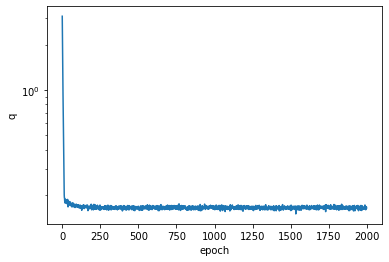

In [16]:
plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')

In [17]:
# save the list
np.save(os.path.join(model_dir,model_name+'.npy'),loss_train)

In [18]:
print('Learned parameters:')
print('Restriction kernel:', mlist[0][0][0])
print('Interpolation kernel:', mlist[1][0][0])

Learned parameters:
Restriction kernel: tensor([[0.3664, 0.5482, 0.3658],
        [0.5472, 0.7654, 0.5462],
        [0.3659, 0.5464, 0.3648]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.3664, 0.5482, 0.3658],
        [0.5472, 0.7654, 0.5462],
        [0.3659, 0.5464, 0.3648]])


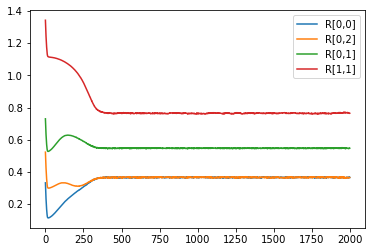

In [19]:
plt.plot(kernel_train[:,0,0], label="R[0,0]")
plt.plot(kernel_train[:,0,2], label="R[0,2]")
plt.plot(kernel_train[:,0,1], label="R[0,1]")
plt.plot(kernel_train[:,1,1], label="R[1,1]")
plt.legend()

In [20]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

0 0.8366839289665222
1 0.17499423027038574
2 0.03816119581460953
3 0.008599914610385895
4 0.0019523855298757553
5 0.00045029548346064985
6 0.00010367936920374632
7 2.410215893178247e-05
8 5.634694389300421e-06
9 1.5573205018881708e-06
Solution converges after 10 multi-grid iterations 


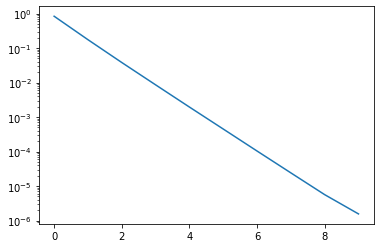

Multigrid solution:


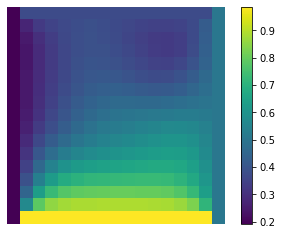

Solution from dataset:


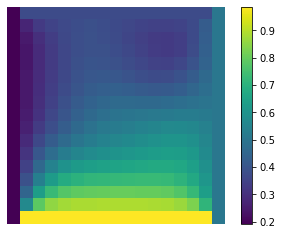

Error (dataset v.s. mg):


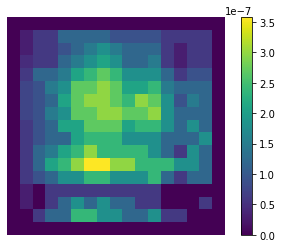

In [21]:
EPS = 5e-6
n_multigrid = 0
res_arr = []
res = 1
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model(f_mg, bc_idx_mg, bc_value_mg, 1)
err_occured = False
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [22]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

In [23]:
model_linear = MultiGrid(n, linear_tensor_P)

1.0 0.916393518447876
2.124408630299774 1.6283329725265503
1.309018879027876 3.2677605152130127
1.626386930940612 6.476032733917236
1.4488798055441405 12.853250503540039
1.5332077073734023 25.507904052734375
1.4895186031203174 50.62335205078125
1.511211311159908 100.46834564208984
1.5002008320102305 199.3926544189453
1.5057241945128779 395.7233581542969
1.5029322553626145 785.3734130859375
1.5043368891993334 1558.695068359375
1.5036282888526897 3093.471435546875
1.5039833738671113 6139.50244140625
1.5038020551044489 12184.8623046875
1.5038906204056925 24183.005859375
1.5038459441940752 47995.375
1.5038675941552242 95255.328125
1.5038578826803783 189050.734375
1.5038632311771687 375203.84375
1.5038607172811238 744656.375
1.503859210126284 1477904.25
1.5038620272048122 2933157.25
1.5038611423700785 5821357.0
1.5038607180040875 11553504.0
1.5038614547120523 22929928.0
1.5038629959519454 45508304.0
1.503863645167742 90318720.0
1.5038630084309428 179252432.0
1.5038647151983278 355755456.0
1

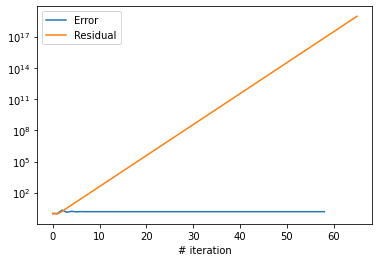

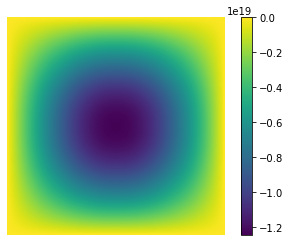

In [24]:
# Multigrid implementation
n = 2**8
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [25]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

print("q is: ", compute_q(res_arr_Vcycle))

q is:  inf
